<a href="https://colab.research.google.com/github/abolfazl328/horse-or-human-classification/blob/main/horse_or_human.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sklearn

# %tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras


import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import RMSprop


# Get Data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sanikamal/horses-or-humans-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/horses-or-humans-dataset


In [ ]:
import os

contents = os.listdir(path+"/horse-or-human/train")

for item in contents:
    print(item)

humans
horses


In [ ]:
# Directory with our training horse pictures
train_horse_dir = os.path.join(path+"/horse-or-human/train/horses")

# Directory with our training human pictures
train_human_dir = os.path.join(path+"/horse-or-human/train/humans")

# Directory with our validation horse pictures
validation_horse_dir = os.path.join(path+"/horse-or-human/validation/horses")

# Directory with our validation human pictures
validation_human_dir = os.path.join(path+"/horse-or-human/validation/humans")

In [ ]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse46-4.png', 'horse40-1.png', 'horse06-2.png', 'horse07-7.png', 'horse48-3.png', 'horse32-5.png', 'horse08-2.png', 'horse50-7.png', 'horse23-3.png', 'horse11-8.png']
['human06-23.png', 'human16-08.png', 'human14-28.png', 'human16-13.png', 'human12-30.png', 'human16-16.png', 'human11-03.png', 'human13-08.png', 'human08-00.png', 'human10-03.png']


In [ ]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


In [ ]:

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0


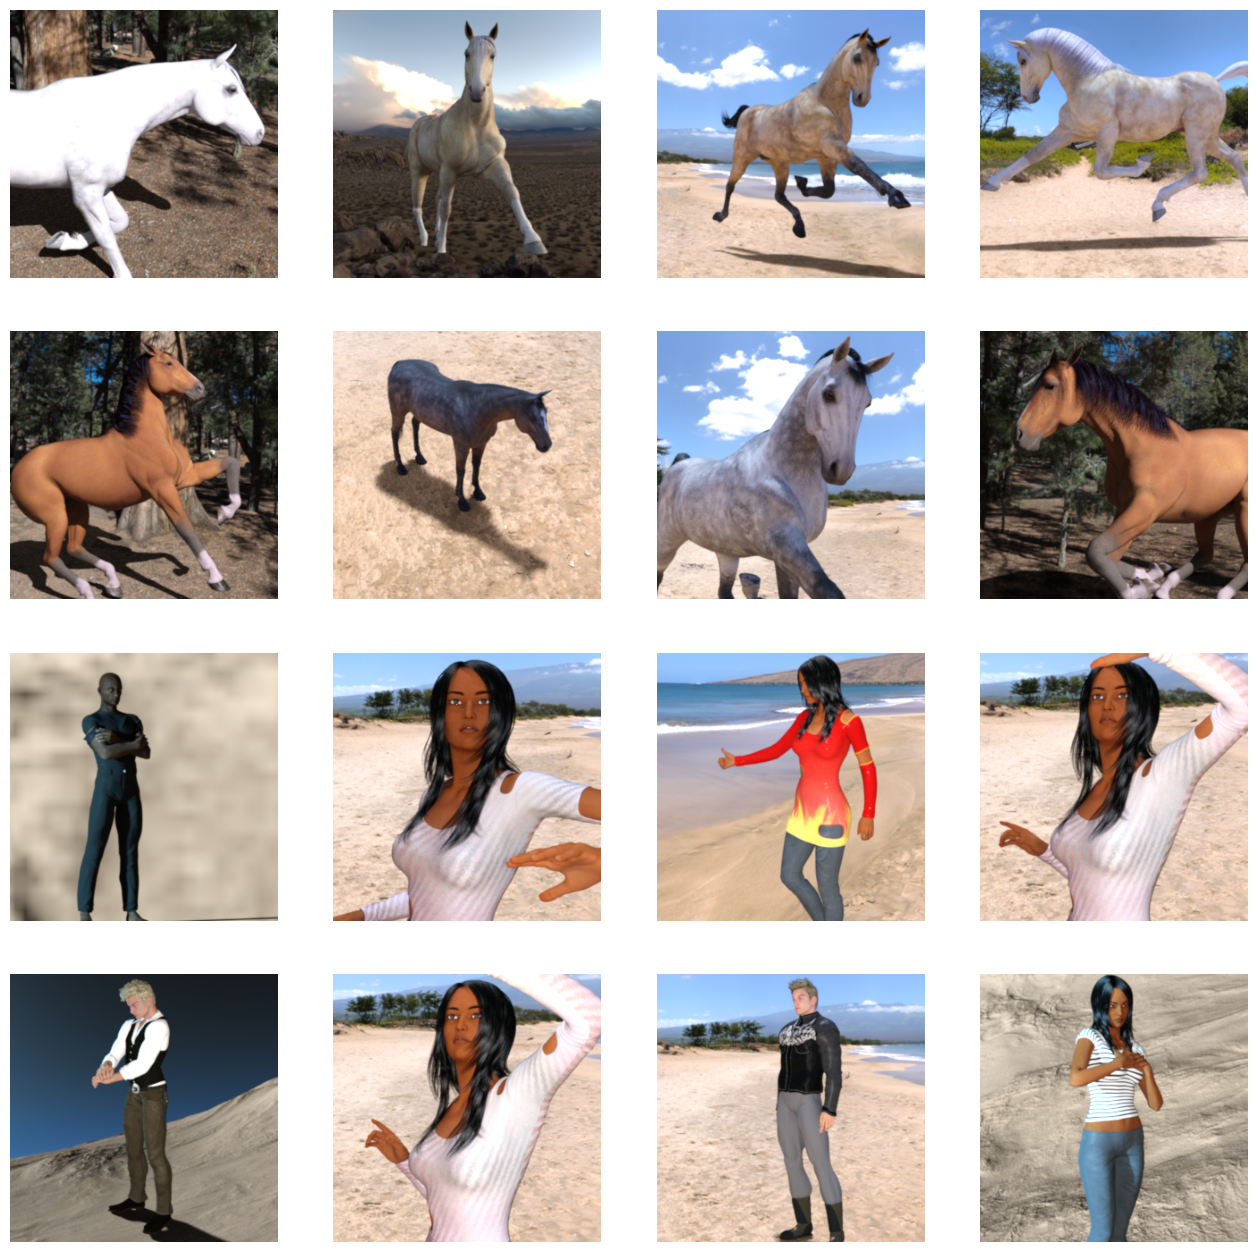

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices 0         start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    path+"/horse-or-human/train",
    target_size=(300, 300),
    batch_size=128,
    class_mode="binary"
)

valid_generator = validation_datagen.flow_from_directory(
    path+"/horse-or-human/validation",
    target_size=(300, 300),
    batch_size=32,
    class_mode="binary"
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
zero = 0
one = 0
for i in valid_generator.classes:
  if i == 0:
    zero+=1
  else:
    one+=1
print(zero)
print(one)
print(valid_generator.classes)

128
128
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D

model = tf.keras.models.Sequential([
                                    # The first convolution
                                    # Input image has 3 bytes color
                                    tf.keras.layers.Conv2D(16, (3, 3), activation="relu", input_shape=(300, 300, 3)),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    # The second convolution
                                    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    # The third convolution
                                    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    # The fourth convolution
                                    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    # The fifth convolution
                                    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    # Flatten the results to feed in Deep Neural Network
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation="relu"),
                                    tf.keras.layers.Dense(1, activation="sigmoid")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# summary
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def get_early_stop(patience=3, monitor='val_loss', min_delta=0.001):
    return EarlyStopping(
        monitor=monitor,     # what to monitor ('val_loss' is safest)
        patience=patience,   # wait for this many epochs with no improvement
        min_delta=min_delta, # ignore tiny improvements
        verbose=1,           # print when stopping
        restore_best_weights=True # go back to best epoch automatically
    )

In [ ]:
# compile
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              # loss='sparse_categorical_crossentropy',
              # optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
x_val, y_val = next(valid_generator)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("Unique labels in this batch:", np.unique(y_val))

x_val shape: (32, 300, 300, 3)
y_val shape: (32,)
Unique labels in this batch: [0. 1.]


In [ ]:
early_stop = get_early_stop(patience=5, monitor='accuracy')
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5420 - loss: 0.6858 - val_accuracy: 0.5000 - val_loss: 0.6685
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6598 - loss: 0.6425 - val_accuracy: 0.5586 - val_loss: 0.6138
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7019 - loss: 0.5868 - val_accuracy: 0.8594 - val_loss: 0.5062
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8663 - loss: 0.4857 - val_accuracy: 0.8281 - val_loss: 0.4386
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8735 - loss: 0.4001 - val_accuracy: 0.9102 - val_loss: 0.3043
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8760 - loss: 0.3567 - val_accuracy: 0.8750 - val_loss: 0.2972
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9304 - loss: 0.2449 - val_accuracy: 0.8125 - val_loss: 0.5692
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9566 - loss: 0.1597 - val_accuracy: 0.8242 - val_loss: 0.6129
Epoch 9/2

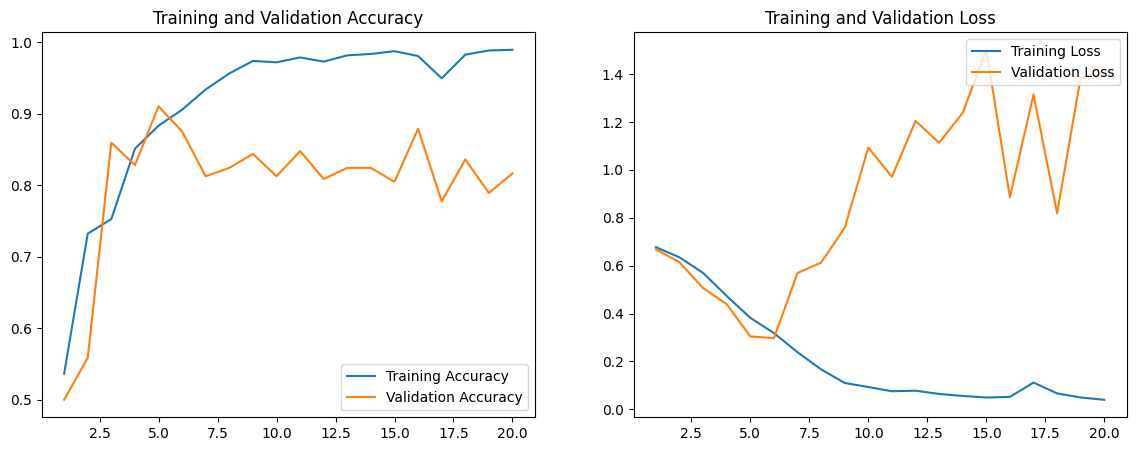

In [ ]:
# plot
import matplotlib.pyplot as plt

# Extract history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
from PIL import Image
import os

In [ ]:
image_folder = './test'
true_labels = [1, 0, 1, 0]
image_files = ['human1.jpeg', 'horse1.jpeg', 'human2.jpeg', 'horse2.jpeg']

In [ ]:
import numpy as np
from PIL import Image

def manual_preprocess(img_path, target_size=(300, 300)):
    img = Image.open(img_path).convert("RGB")
    img = img.resize(target_size)
    arr = np.array(img) / 255.0
    return np.expand_dims(arr.astype("float32"), axis=0), arr  # return both batched and raw for plotting


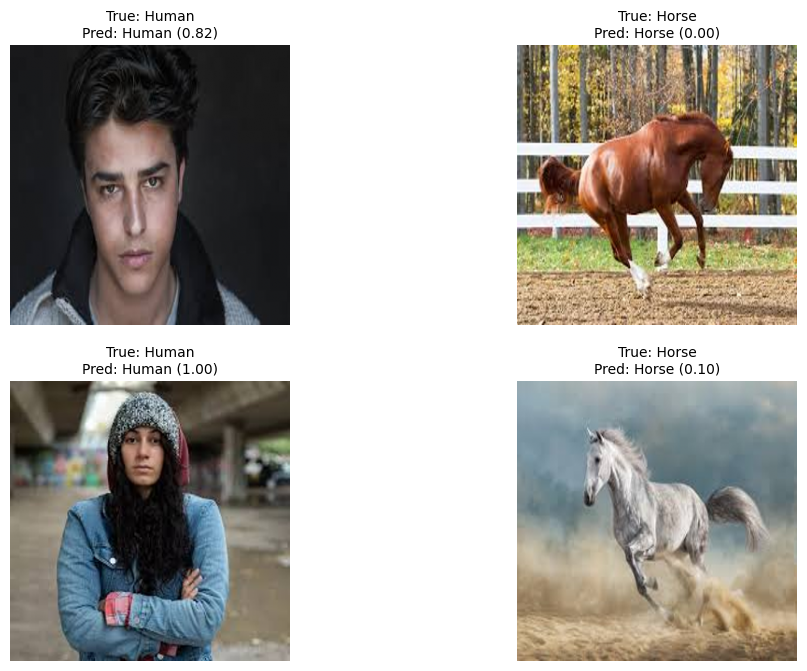

In [ ]:
plt.figure(figsize=(12, 8))

for i, path in enumerate(image_files):
    img_batched, img_raw = manual_preprocess(os.path.join(image_folder,path))
    pred_prob = model.predict(img_batched, verbose=0)[0][0]
    pred_label = 1 if pred_prob > 0.5 else 0

    # Convert labels to text
    true_text = "Human" if true_labels[i] == 1 else "Horse"
    pred_text = f"{'Human' if pred_label == 1 else 'Horse'} ({pred_prob:.2f})"

    # Plot
    plt.subplot(2, 2, i+1)
    plt.imshow(img_raw)
    plt.axis("off")
    plt.title(f"True: {true_text}\nPred: {pred_text}", fontsize=10)

# plt.tight_layout()
# plt.show()